<a href="https://colab.research.google.com/github/sophiaalexander/GANs-for-High-Schoolers/blob/master/Looking_Inside_GAN_Generators_How_Do_They_Work%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Looking Inside GAN Generators: How Do They Work?

Adapted from David Bau's Jupyter Notebook "Exploring a Generator with GANdissect."

#### Introduction to GANS, PROGANS and GAN Dissection
Hi there! Welcome to this jupyter notebook! In this notebook, we will be taking a closer look into the functions of **GANs**. The objective for this tutorial is to look inside a GAN (Generative Adversarial Network) generator to see what is happening inside and how it functions. By looking into what goes on inside of a GAN, we'll be able to better understand it's functions in machine learning and artifical intelligences, while also learning some of its applications. In this specific tutorial, we will be looking at how the inside processes of a generator allow programs such as **GAN Dissection** to manipulate (activate and deactivate) neurons and generate photo realistic outputs. 

In the previous jupyter tutorial, an adapted version of Alex Andonian's "Training a GAN" (http://ganocracy.csail.mit.edu/tutorial/tutorial.html#tutorial3), we got to look into and run the code that set up and trains GANs. Remember what a **GAN** is? A GAN, Generative Adversarial Network, is a strategy where there are two competing (adversarial) networks. The first network, the **generator network**, is creating new images from the information it has learned about the dataset from training with the discriminator network. In the beginning an unlearned generator will be producing totally random outputs, but as the network continues to run, the generated outputs will continue to become more realistic and the accuracy of output will improve. The goal of the generator network is to 'trick' the second **discriminator network**. As the system continues to run 100s and 1000s of times, the generator will learn how to produce more realistic images and the discriminator will continue to learn how to distinguish the generated images from the real dataset.

Here's a linear diagram of a GAN:


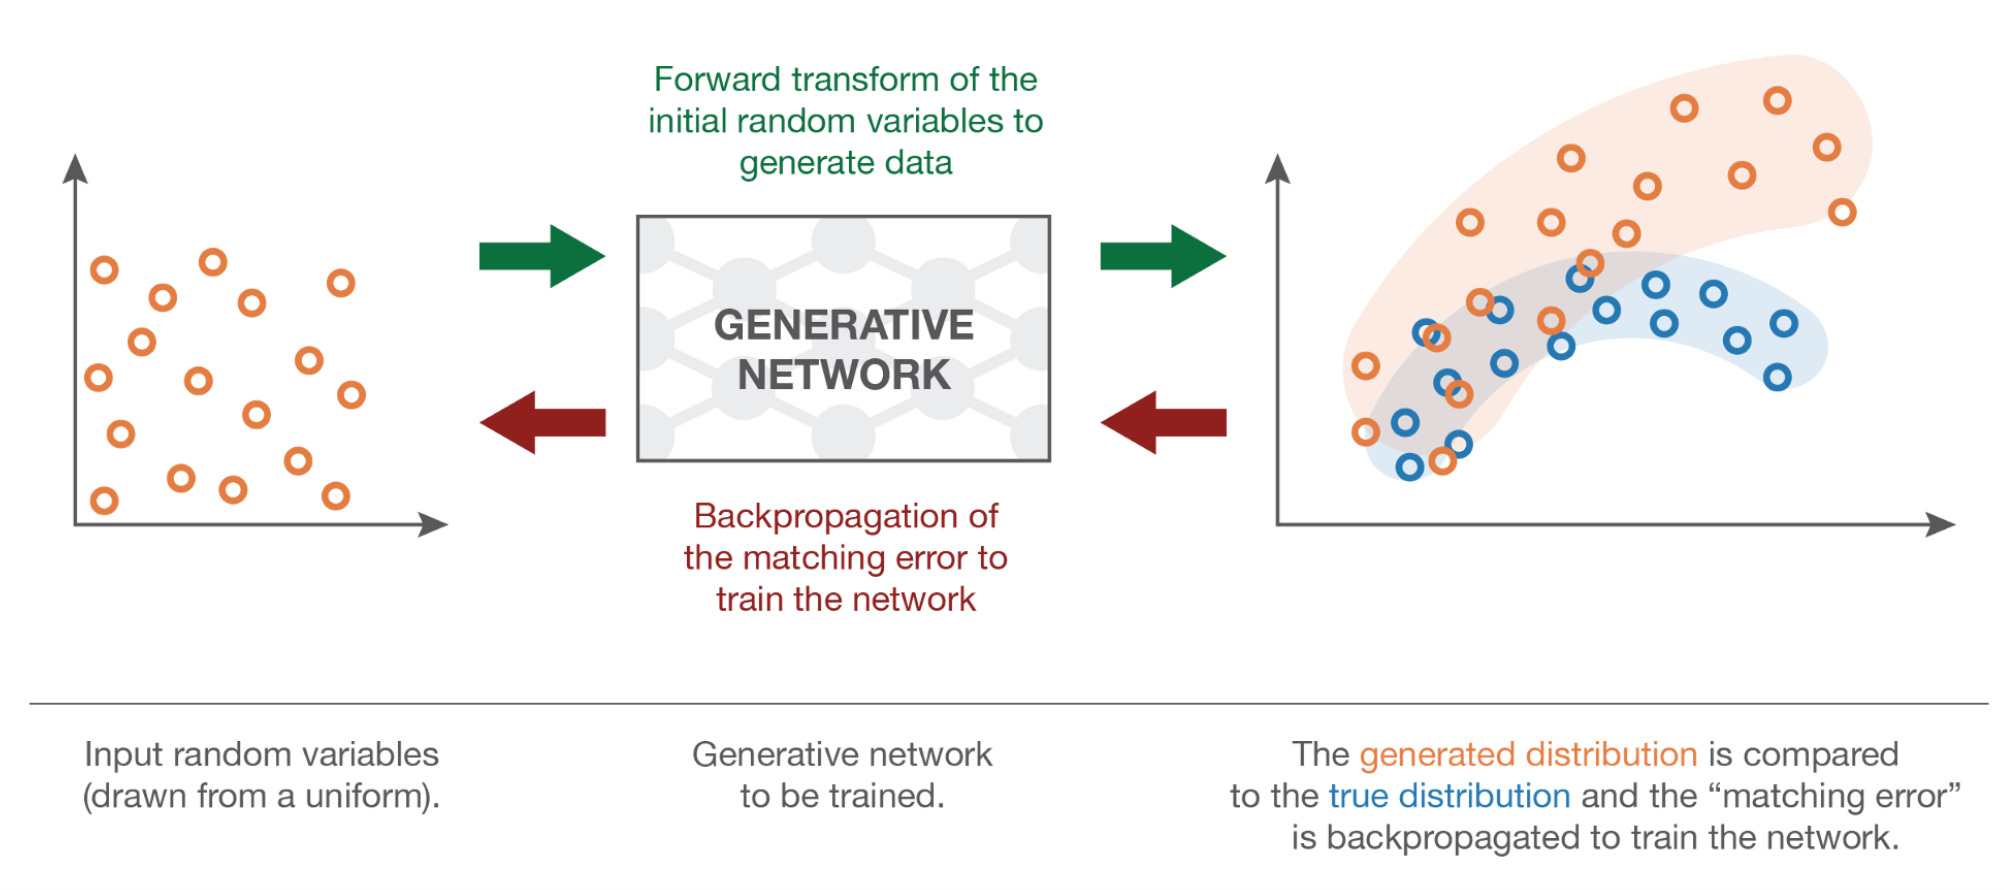

In [0]:
Image('Screen Shot 2019-08-01 at 11.18.27 AM.png')

So what is **GAN Dissect** and how does it work?
This version of GAN Dissect uses a type of GAN called a progressive GAN or **[PROGAN](https://towardsdatascience.com/progressively-growing-gans-9cb795caebee)**. 

What's a PROGAN?
A progressive GAN is a type of GAN that is made up of multiple layers, known as multi-scale architecture. The GAN starts with a small and low resolution layer at first, but as it learns and builds a better understanding of the dataset, the GAN can produce more accurate and higher resolution layers that build off one another. 


Examples of outputs of a PROGAN trained on celebrity faces to generate "new celebrities":


The PROGANs used in GAN Dissection, like the human brain, use a complex network of active and firing neurons. These neurons learn to fire at different areas/objects within a dataset. The neurons learn and improve their accuracy in recognizing and activating to the objects they correlate to with each addition of a foundational and trained layer. When thinking about the function of these neurons,we want to know 'which convolutional units correlate to an object class that humans would recognize?' How can we use these neurons to improve a GANs output? How can we tell which neurons associate to which units?


GAN Dissection stores datasets of images and directly activates/deactivates those sets of neurons in a deep network that is trained to generate new images. A fun example of these trained networks at work is the GAN paint tool, where neurons specific to a certain object class can render new images by using neurons to 'paint' with object level control. The neuron settings can be manually changed to either ablate (delete) or add a specific unit in the image. 


Check out this link http://gandissect.res.ibm.com/ganpaint.html?project=churchoutdoor&layer=layer4 to try painting with these neurons!![



We begin with some imports and jupyter setup.

These import functions allow us to download external libraries into jupyter notebooks. There is no immediate output of importing libraries, it just sets up information for later code.



In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload
mpl.rcParams['lines.linewidth'] = 0.25
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.linewidth'] = 0.25

The Torch library is a machine learning library, which allows jupyter access to deep learning algorithms. 


In [0]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Running pytorch', torch.__version__, 'using', device.type)

Running pytorch 1.1.0 using cpu


## Inside a GAN generator

For this specific tutorial with Gan Dissect, we are using a pretrained PROGAN. 

PROGAN NETWORKS:
![1_lStHChxfyLB3S7wUW3Quiw.png](attachment:1_lStHChxfyLB3S7wUW3Quiw.png)
![1_SoWghLQBfcW5i7tAuqQamQ.png](attachment:1_SoWghLQBfcW5i7tAuqQamQ.png)

Below I download and start running a model for outdoor churches.

But, you can use any of these models. To try using a different one, just remove the hashtag infront of the model you want to run (this lets the notebook know that it is no longer a comment, and that it can read it as code). Just make sure you are running one model at a time, so remember to put a hashtag on the model you nolonger want to run.

After we create the model, I just print out all the layers.

In [0]:
import torchvision
import torch.hub
from netdissect import nethook, proggan

# n = 'proggan_bedroom-d8a89ff1.pth'
n = 'proggan_churchoutdoor-7e701dd5.pth'
# n = 'proggan_conferenceroom-21e85882.pth'
# n = 'proggan_diningroom-3aa0ab80.pth'
# n = 'proggan_kitchen-67f1e16c.pth'
# n = 'proggan_livingroom-5ef336dd.pth'
# n = 'proggan_restaurant-b8578299.pth'

url = 'http://gandissect.csail.mit.edu/models/' + n
try:
    sd = torch.hub.load_state_dict_from_url(url) # pytorch 1.1
except:
    sd = torch.hub.model_zoo.load_url(url) # pytorch 1.0
model = proggan.from_state_dict(sd).to(device)
model

ModuleNotFoundError: ignored

## Running the model

The GAN generator is just a function z->x that transforms a random z (input) to realistic images x (output).

![gan.png](attachment:gan.png) 
This image shows the generator and discriminator functions. In the generator function, Z represents the input noise and X represents samples from either the data or created by the generator. In the discriminator function, Y is the discriminators prediction to whether X is from the data or the generator. 

To generate images, all we need is a source of random z.  Let's make a micro dataset with a few random z. The tasl of the code shown below is to simply randomize the input information we are pulling for the zdataset. In this code, "seed" is what is contributing the randomization. It assigns a number to the data and randomly selects to yield a fair model that we will use to generate new pictures. 

When this code is run, you will see the shape of the output (torch.Size) appear. Shape describes the dimensions of random z input in list form. 



In [0]:
from netdissect import zdataset
zds = zdataset.z_dataset_for_model(model, size=30, seed=5555)
len(zds), zds[0][0].shape

After feeding in the zdataset as the input (z), we can use this model to generate a single image output (x).

In [0]:
# Look at the output data - print a few pixel values
model(zds[0][0][None,...].to(device))[0,0,:10]

## Visualizing the output

The netdissect toolkit comes with a few simple visualization tools for examining images in notebooks.

  * renormalize turns tensors that were normalized as [-1...1] back into PIL images.
  * show takes nested arrays of images and text and lays then out as grids and tables.
  
Let's look at the images we created with our model.

In [0]:
from netdissect import renormalize, show
# from IPython.display import display

show([
    [renormalize.as_image(model(z[None,...].to(device))[0])]
    for [z] in zds
])


## Analyzing a model

To analyze what is happening inside of a model, we can wrap it with an InstrumentedModel, which makes it easy to hook or modify a particular layer. Hooks allow a layer to hold on to its output after computation. By keeping this information after the code has been executed, it saves the data so that it can be analyzed. 

Let's start by picking a layer to look at! Here we're picking a layer in the early-middle part of this generator, but try it out with whichever ones you like!

In [0]:
# TODO: add a summary of what InstrumentedModel can do.
# retain a layer, get a retained layer, edit a layer

from netdissect import nethook

# Don't re-wrap it, if it's already wrapped (e.g., if you press enter twice)
if not isinstance(model, nethook.InstrumentedModel):
    model = nethook.InstrumentedModel(model)
model.retain_layer('layer4')

Now we can run the model and inspect the internal units.

In [0]:
# Run the model
img = model(zds[0][0][None,...].to(device))

# Because we have wrapped our model with an InstrumentedModel, the model has retained the output of layer4.
acts = model.retained_layer('layer4')

# Now take a look at the retained information.  How much data is it? *Remember the shape describes the dimensions and size of the output.
acts.shape

In [0]:
# Let's just look at the 0th convolutional channel.
print(acts[0,0])


This tensor list is a type of format for how the computer is perceiving the data that was collected by the neurons. The greater numbers are associated with highger activation levels of the neurons. These units depict how the neuron reacted to the image and the units which correlate to the neurons activity. 

This set of numbers can be difficult to understand, so let's take a look at what's really happening and visualize this activation data instead of just looking at the numbers.

Net dissection comes with an ImageVisualizer object for visualizing grid data as an image in a few different ways.  Here is a heatmap that shows the same data as the tensor above:

In [0]:
from netdissect import imgviz
iv = imgviz.ImageVisualizer(100)
iv.heatmap(acts[0,1], mode='nearest')

##### This heat map shows colors ranging from black to white:

White is associated with the highest activiity of firing neurons. The white areas show what regions the neuron is reacting to the most. 
This is how we find out which neurons are associated to certain regions of a unit.


If you tell IV to dereference the activations for you, it scales heatmaps according to global statistics.

Each unit has a different scale, which makes the heatmaps harder to interpret. We can normalize the scales by collecting stats. 

What is happening with unit 418? Below you will see that unit 418 is now normalized, whereas the other units are unchanged (unnormalized). Normalization makes it much easier to visually see the activations within the specific unit, making it clearer to interpret. 

In [0]:
show(
    [['unit %d' % u,
      [iv.image(img[0])],
      [iv.masked_image(img[0], acts, (0,u))],
      [iv.heatmap(acts, (0,u), mode='nearest')],
     ] for u in range(414, 420)]  
)

## Collecting the statistics for every unit

How do we know what these units are showing? What does that mean? To get a better understanding, we want to find out per-channel minimum or maximum values, means, medians, quantiles, etc.

We want to treat each pixel as its own sample for all the channels.  For example, here are the activations for one image as an 8x8 tensor over with 512 channels.  We can disregard the geometry (shape of the dimensions) and just look at it as a 64x512 sample matrix, that is 64 samples of 512-dimensional vectors.

In [0]:
print(acts.shape)
print(acts.permute(0, 2, 3, 1).contiguous().view(-1, acts.shape[1]).shape)

Net dissection has a tally package that tracks quantiles over large samples.

To use it, just define a function that returns sample matrices like the 64x512 above, and then it will call your function on every batch and tally up the statistics.

In [0]:
from netdissect import tally

# To collect stats, define a function that returns 2d [samples, units]
def compute_samples(zbatch):
    _ = model(zbatch.to(device))          # run the model
    acts = model.retained_layer('layer4') # get the activations, and flatten
    return acts.permute(0, 2, 3, 1).contiguous().view(-1, acts.shape[1])

# Then tally_quantile will run your function over the whole dataset to collect quantile stats
rq = tally.tally_quantile(compute_samples, zds)

# Print out the median value for the first 20 channels
rq.quantiles(0.5)[:20]

In [0]:
torch.tensor(3).dtype

## Exploring the statistics and grounded facts

The rq object tracks a sketch of all the quantiles of the sampled data.  For example, what is the mean, median, and percentile value for each unit?

In [0]:
# This tells me now, for example, what the means are for channel,
# rq.mean()
# what median is,
# rq.quantiles(0.5)
# Or what the 99th percentile quantile is.
# rq.quantiles(0.99)

(rq.quantiles(0.8) > 0).sum()

The quantiles can be plugged directly into the ImageVisualizer to put heatmaps on an informative per-unit scale.  When you do this:

   **Heatmaps are shown on a scale from black to white from 1% lowest to the 99% highest value. These values correlate to the level of activation of the neurons for that unit.**
   
   **Masked image lassos are shown at a 95% percentile level.** This is the default setting, the percentile level can be changed. The greater percentiles are where the highest values of activation for that convolutional channel occured.  
   
Now unit 418 doesn't drown out the other ones in the visualization.

In [0]:
iv = imgviz.ImageVisualizer(100, quantiles=rq)
show([
    [  # for every unit, make a block containing
       'unit %d' % u,         # the unit number
       [iv.image(img[0])],    # the unmodified image
       [iv.masked_image(img[0], acts, (0,u))], # the masked image
       [iv.heatmap(acts, (0,u), mode='nearest')], # the heatmap
    ]
    for u in range(414, 420)
])

## Visualizing the highest activating images

A useful way to visualize units is to sort a sample, in order of highest activation.  tally_topk does this.

Like torch.topk, it returns both the top k values and the top k indexes.  But instead of acting on a single tensor, it iterates over the whole data set.

In [0]:
def compute_image_max(zbatch):
    image_batch = model(zbatch.to(device))
    return model.retained_layer('layer4').max(3)[0].max(2)[0]

topk = tally.tally_topk(compute_image_max, zds)
topk.result()[1].shape

In [0]:
# For each unit, this function prints out unit masks from the top-activating images
def unit_viz_row(unitnum, percent_level=None):
    out = []
    for imgnum in topk.result()[1][unitnum][:8]:
        img = model(zds[imgnum][0][None,...].to(device))
        acts = model.retained_layer('layer4')
        out.append([imgnum.item(),
                    # [iv.image(img[0])],
                    [iv.masked_image(img[0], acts, (0, unitnum), percent_level=percent_level)],
                    # [iv.heatmap(acts, (0, unitnum), mode='nearest')],
                   ])
    return out

show(unit_viz_row(60))

## Giving semantic labels to the neurons

Above we can see the regions of highest neuron activity, but how do we label what these neurons reacting the most strongly to? How do we categorize these neurons? Let's quantify what's inside these images by segmenting them.
First, we create a segmenter network.  (We use the [Unified Perceptual Parsing segmenter by Xiao, et al](https://arxiv.org/abs/1807.10221).

Note that the segmenter we use here requires a GPU (Graphics Processing Unit) in order to operate.  

If you are operating on only a CPU, you can skip to step "Examining units that select for trees" below.

To see these operations, try going to this notebook with its Google's Colaboratory format, where you can access this same tutorial along with free accessible gpus. 

In [0]:
from netdissect import segmenter

segmodel = segmenter.UnifiedParsingSegmenter(segsizes=[256])
seglabels = [l for l, c in segmodel.get_label_and_category_names()[0]]
print('segmenter has', len(seglabels), 'labels')

Then we create segmentation images for the dataset.  Here tally_cat just concatenates batches of image (or segmentation) data.

  * `segmodel.segment_batch` segments an image
  * `iv.segmentation(seg)` creates a solid-color visualization of a segmentation
  * `iv.segment_key(seg, segmodel)` makes a small legend for the segmentation

In [0]:
from netdissect import upsample
from netdissect import segviz

imgs = tally.tally_cat(lambda zbatch: model(zbatch.to(device)), zds)
seg = tally.tally_cat(lambda img: segmodel.segment_batch(img.cuda(), downsample=1), imgs)

from netdissect.segviz import seg_as_image, segment_key
show([
    (iv.image(imgs[i]),
     iv.segmentation(seg[i,0]),
     iv.segment_key(seg[i,0], segmodel)
    )
    for i in range(len(seg))
])

## Identifying the units 

Some units align well with visual concepts.

To identify these, we will collect *conditional* activation statistics.

In addition to regular quantile statistics, we will collect quantile statistics over all the subsets of pixels in which a particular visual concept is present.

To do this, we will use the `tally_conditional_quantile` loop.

It expects its `compute` function to return a list of sample statistics, each one keyed by a condition that is present.

Here is how we do it.

In [0]:
# We upsample activations to measure them at each segmentation location.
upfn = upsample.upsampler((64, 64), (8, 8))

def compute_conditional_samples(zbatch):
    image_batch = model(zbatch.to(device))
    seg = segmodel.segment_batch(image_batch, downsample=4)
    upsampled_acts = upfn(model.retained_layer('layer4'))
    return tally.conditional_samples(upsampled_acts, seg)

# Run this function once to sample one image
sample = compute_conditional_samples(zds[0][0].cuda()[None,...])

# The result is a list of all the conditional subsamples
[(c, d.shape) for c, d in sample]

In [0]:
cq = tally.tally_conditional_quantile(compute_conditional_samples, zds)

Conditional quantile statistics let us compute lots of relationships between units and visual concepts.

For example, IoU is the "inside over outside" ratio, measuring how much overlap there is between the top few percent activations of a unit and the presence of a visual concept.  We can estimate the IoU ratio for all pairs between units and concepts with these stats:

In [0]:
iou_table = tally.iqr_from_conditional_quantile(cq, cutoff=0.95)
iou_table.shape

Now let's view a few of the units, labeled with an associated concept, sorted from highest to lowest IoU.

In [0]:
unit_list = sorted(enumerate(zip(*iou_table.max(1))), key=lambda k: -k[1][0])

for unit, (iou, segc) in unit_list[:5]:
    print('unit %d: %s (iou %.2f)' % (unit, seglabels[segc], iou))
    show(unit_viz_row(unit))

## Examining units that select specifically for trees

Now let's filter for units that were labeled as 'tree' units.

In [0]:
tree_units = [(unit, iou, segc) for unit, (iou, segc) in unit_list if seglabels[segc] == 'tree'][:10]
# If you can't run the segmenter, uncomment the line below and comment the one above.
# tree_units = [365, 157, 119, 374, 336, 195, 278, 76, 408, 125]

for unit, iou, segc in tree_units:
    print('unit %d, iou %.2f' % (unit, iou))
    show(unit_viz_row(unit))

## Editing a model by altering units

Now let's try changing some units directly to see what they do.

We we will use `model.edit_layer` to do that.

This works by just allowing you to define a function that edits the output of a layer.

We will edit the output of `layer4` by zeroing ten of the tree units.

In [0]:
def zero_out_tree_units(data, model):
    data[:, tree_units, :, :] = 0
    return data

model.edit_layer('layer4', rule=zero_out_tree_units)
edited_imgs = tally.tally_cat(lambda zbatch: model(zbatch.to(device)), zds)
show([(['Before', [renormalize.as_image(imgs[i])]],
       ['After', [renormalize.as_image(edited_imgs[i])]]) for i in range(len(zds))])

## Hey! Interested in more??

Here are some interesting articles about GANs:
* https://www.theverge.com/2019/3/5/18251267/ai-art-gans-mario-klingemann-auction-sothebys-technology
* https://towardsdatascience.com/gangogh-creating-art-with-gans-8d087d8f74a1
* https://towardsdatascience.com/search?q=gan%20dissection

Make your own AI art!:
https://deepart.io/

Try these additional experiments:
   * Instead of zeroing the units, try setting them negative, e.g., to -2.
   * Instead of turning the units off, try turning them on, e.g., set them to 10.
   * Try turning on the units in just the left-half of the images.
   * Try altering other sets of units.
It is not hard to create a 'painting' program using these effects.  To demo one, visit http://gandissect.csail.mit.edu/


## Optimizing cutoff thresholds to maximize relative mutual information

In [0]:
model.remove_edits()


One last visualization - just showing masks and units side-by-side for a few examples

In [0]:
iv2 = imgviz.ImageVisualizer(256, quantiles=rq)
model.remove_edits()
def compute_acts(zbatch):
    model(zbatch.to(device))
    return model.retained_layer('layer4')

acts = tally.tally_cat(compute_acts, zds).cpu()
unit = 365
segc = 4

if True:
    show([
        (iv2.image(imgs[i]),
         iv2.segmentation(seg[i,0], 4),
         iv2.heatmap(acts, (i, unit), mode='nearest'),
         iv2.masked_image(imgs[i], acts, (i, unit))
        )
        for i in [0,2,4,9,25,28]
    ])
    
if False:
    show([
        (iv2.image(imgs[i]),
         iv2.segmentation(seg[i,0], 4),
         iv2.heatmap(acts, (i, unit), mode='nearest'),
         iv2.masked_image(imgs[i], acts, (i, unit))
        )
        for i in [1,5,7,8,10,11]
    ])

if False:
    show([
        (iv2.image(imgs[i]),
         iv2.segmentation(seg[i,0], 11),
         iv2.heatmap(acts, (i, 149), mode='nearest'),
         iv2.masked_image(imgs[i], acts, (i, 149))
        )
        for i in [0,2,4,9,25,28]
    ])

## Detail - optimizing cutoff threshold

We can do better if we try to remove bias having to do with the cutoff threshold.

In the above, we evaluate the unit by applying a cutoff at a fixed 95% percentile, which biases our search for matching visual concepts to favor of objects that take about 5% of pixels on average, such as trees.

To avoid this bias, we can choose to look at each (unit, concept) pair at the best possible unit threshold for that pair.  Bellow, we identify a "maximally informative" threshold - that is, we find a threshold for the unit that maximizes the relative mutual information between the unit and the concept.   IQR stands for "information quatlity ratio", and it's mutual information divided by joint entropy.

In [0]:
import math

cutoffs = 1 - torch.logspace(-3, math.log10(0.5), 50)
iqr_grid = tally.iqr_from_conditional_quantile(cq, cutoff=cutoffs, min_batches=3)
print(iqr_grid.shape)


This is small enough data that we can find levels that maximize iqr by just doing a simple grid search. Here is an example of finding a cutoff that maximizes the overlap between unit 3 and concept 340.

In [0]:
plt.plot(cutoffs.numpy(), iqr_grid[3,340].numpy())
# plt.figure()
# plt.plot(cutoffs.numpy(), iou_table[3,340].numpy())
maxval, maxindex = iqr_grid[3,340].max(0)
print(maxval, cutoffs[maxindex])

Here we collect IoU measures at each of the best cutoff values.

In [0]:
best_cutoff = cutoffs[iqr_grid.max(2)[1]]
iou_grid = tally.iou_from_conditional_quantile(cq, cutoff=cutoffs)
best_iou = iqr_grid.gather(2, iqr_grid.max(2)[1][...,None])[...,0]
best_iou

Finally, we can visualize the units that best match concepts based on these optimal cutoffs.

Note that this procedure has allowed us to identify both units for very common general concepts like "sky" (at threshold 73.5%) and very rare narrow concepts like "door" (at threshold 99.6%).

In [0]:
iv = imgviz.ImageVisualizer(100, quantiles=cq.conditional(0))
best_unit_list = sorted(enumerate(zip(*best_iou.max(1))), key=lambda k: -k[1][0])
for unit, (iou, segc) in best_unit_list[:50]:
    print('unit %d: %s (iou %.2f at cutoff %.1f%%)' % (unit, seglabels[segc], iou, 100*best_cutoff[unit, segc]))
    show(unit_viz_row(unit, percent_level=best_cutoff[unit, segc]))

Special thanks to Lucy Chai, Àgata Lapedriza, and Katherine Gallagher for testing this notebook.